# TP2 - Text-mining and chatbots [BRAT]
**Students**:
- Thanh Gia Hieu KHUONG
- Ragi BHATT
- Benedictus Kent RACHMAT

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from collections import Counter, defaultdict

# Define the path to the QUAERO FrenchMed TP2021
PATH="QUAERO_FrenchMed_TP2021"

## Read BRAT data

In [19]:


def parse_brat_annotation(ann_data):
    entities = {}
    entity_types = set()
    unique_entities = set()

    for line in ann_data:
        if line.startswith('T'):
            parts = line.split('\t')
            entity_id = parts[0]
            entity_info = parts[1]
            entity_text = parts[2].strip()

            entity_type = entity_info.split(' ')[0]
            entities[entity_id] = {'type': entity_type, 'text': entity_text}

            unique_entities.add(entity_text)
            entity_types.add(entity_type)

    return entities, entity_types, unique_entities

def analyze_corpus(path):
    results = {}
    for subset in ['EMEA', 'MEDLINE']:
        for split in ['train', 'dev', 'test']:
            subset_path = os.path.join(path, split, subset)

            # Assuming the structure inside the subsets is similar to the provided 'train/EMEA' structure
            ann_files = [f for f in os.listdir(subset_path) if f.endswith('.ann')]
            txt_files = [f.replace('.ann', '.txt') for f in ann_files]

            # Initialize counters for the subset
            subset_data = {
                'number_of_tokens': 0,
                'total_number_of_entities': 0,
                'number_of_unique_entities': 0,
                'number_of_entity_types': 0,
                'number_of_entities_per_type': Counter()
            }

            for ann_file, txt_file in zip(ann_files, txt_files):
                with open(os.path.join(subset_path, txt_file), 'r') as f:
                    txt_data = f.read()

                with open(os.path.join(subset_path, ann_file), 'r') as f:
                    ann_data = f.readlines()

                # Parse the BRAT annotations
                entities, entity_types, unique_entities = parse_brat_annotation(ann_data)

                # Count the total number of tokens in the text file
                tokens = re.findall(r'\b\w+\b', txt_data)
                subset_data['number_of_tokens'] += len(tokens)

                # Update entity counts for the subset
                subset_data['total_number_of_entities'] += len(entities)
                subset_data['number_of_unique_entities'] += len(unique_entities)
                subset_data['number_of_entity_types'] = len(entity_types)  # Assuming entity types don't vary across files

                # Update the number of entities per type
                subset_data['number_of_entities_per_type'].update([entity['type'] for entity in entities.values()])


            # Convert Counter to dict
            subset_data['number_of_entities_per_type'] = dict(subset_data['number_of_entities_per_type'])
            
            # Save the results for the subset
            results[subset + '_' + split] = subset_data

    return results

# Analyze the corpus and get the results
brat_results = analyze_corpus(os.path.join(PATH, "QUAERO_FrenchMed_BRAT/corpus"))
brat_results


{'EMEA_train': {'number_of_tokens': 12806,
  'total_number_of_entities': 2695,
  'number_of_unique_entities': 1337,
  'number_of_entity_types': 10,
  'number_of_entities_per_type': {'GEOG': 22,
   'DEVI': 48,
   'OBJC': 71,
   'CHEM': 727,
   'PROC': 433,
   'DISO': 736,
   'PHYS': 119,
   'LIVB': 273,
   'ANAT': 247,
   'PHEN': 19}},
 'EMEA_dev': {'number_of_tokens': 11434,
  'total_number_of_entities': 2260,
  'number_of_unique_entities': 1208,
  'number_of_entity_types': 9,
  'number_of_entities_per_type': {'OBJC': 50,
   'CHEM': 870,
   'PHEN': 10,
   'PROC': 250,
   'PHYS': 140,
   'DISO': 458,
   'LIVB': 276,
   'GEOG': 29,
   'DEVI': 22,
   'ANAT': 155}},
 'EMEA_test': {'number_of_tokens': 10320,
  'total_number_of_entities': 2204,
  'number_of_unique_entities': 1156,
  'number_of_entity_types': 9,
  'number_of_entities_per_type': {'CHEM': 885,
   'DISO': 316,
   'ANAT': 181,
   'PROC': 269,
   'LIVB': 268,
   'PHYS': 85,
   'OBJC': 53,
   'PHEN': 33,
   'DEVI': 100,
   'GEOG': 

## Read CoNLL data

In [20]:
def get_statistics(dataset_dir):
  statistics = {}
  for split in ['train', 'dev', 'test']:
    for subset in ['EMEA', 'MEDLINE']:
      split_dir = os.path.join(dataset_dir, split, subset)

      if not os.path.exists(split_dir):
        continue

      # Iterate over each file in the split directory
      for file in os.listdir(split_dir):
          file_path = os.path.join(split_dir, file)

          conll_df = pd.read_csv(file_path, sep='\t', header=None, names=['entity', 'start', 'end', 'token'])

          conll_df.dropna(inplace=True)
          conll_df.reset_index(drop=True, inplace=True)

          # Number of tokens
          number_of_tokens = conll_df.shape[0]

          # Number of entities
          entities = conll_df[conll_df['entity'] != 'O'][['entity', 'token']]
          num_entities = len(entities)
          num_entities_types = len(entities['entity'].unique())

          # Number of unique entities
          entities.drop_duplicates(inplace=True)
          number_of_unique_entities = len(entities)

          # Number of entities per type
          entities_per_type = defaultdict(int)
          for entity in entities['entity']:
              entities_per_type[entity] += 1

          statistics[f"{subset}_{split}"] = {
              'number_of_tokens': number_of_tokens,
              'total_number_of_entities': num_entities,
              'number_of_unique_entities': number_of_unique_entities,
              'number_of_entity_types': num_entities_types,
              'number_of_entities_per_type': entities_per_type
          }
  return statistics 
    
conll_results = get_statistics("QUAERO_FrenchMed_TP2021/QUAERO_FrenchMed_conll/corpus")
conll_results

{'EMEA_train': {'number_of_tokens': 15339,
  'total_number_of_entities': 3198,
  'number_of_unique_entities': 1037,
  'number_of_entity_types': 20,
  'number_of_entities_per_type': defaultdict(int,
              {'CHEM-B': 122,
               'PROC-B': 85,
               'CHEM-I': 50,
               'DISO-B': 234,
               'DISO-I': 178,
               'LIVB-B': 49,
               'PROC-I': 46,
               'ANAT-B': 74,
               'ANAT-I': 26,
               'DEVI-B': 11,
               'OBJC-B': 20,
               'LIVB-I': 32,
               'PHEN-B': 12,
               'PHYS-B': 52,
               'PHYS-I': 23,
               'PHEN-I': 3,
               'GEOG-B': 12,
               'GEOG-I': 4,
               'OBJC-I': 3,
               'DEVI-I': 1})},
 'MEDLINE_train': {'number_of_tokens': 11441,
  'total_number_of_entities': 3611,
  'number_of_unique_entities': 2547,
  'number_of_entity_types': 20,
  'number_of_entities_per_type': defaultdict(int,
              {'PRO

## Plot the analysis side-by-side

{'GEOG': 22, 'DEVI': 48, 'OBJC': 71, 'CHEM': 727, 'PROC': 433, 'DISO': 736, 'PHYS': 119, 'LIVB': 273, 'ANAT': 247, 'PHEN': 19}
{'OBJC': 50, 'CHEM': 870, 'PHEN': 10, 'PROC': 250, 'PHYS': 140, 'DISO': 458, 'LIVB': 276, 'GEOG': 29, 'DEVI': 22, 'ANAT': 155}
{'CHEM': 885, 'DISO': 316, 'ANAT': 181, 'PROC': 269, 'LIVB': 268, 'PHYS': 85, 'OBJC': 53, 'PHEN': 33, 'DEVI': 100, 'GEOG': 14}
{'PROC': 573, 'CHEM': 346, 'PHYS': 160, 'DISO': 963, 'ANAT': 495, 'PHEN': 60, 'LIVB': 297, 'DEVI': 39, 'GEOG': 34, 'OBJC': 27}
{'PROC': 569, 'LIVB': 320, 'CHEM': 367, 'PHYS': 151, 'DISO': 892, 'ANAT': 494, 'DEVI': 54, 'PHEN': 49, 'GEOG': 46, 'OBJC': 35}
{'DISO': 988, 'LIVB': 324, 'ANAT': 510, 'PHYS': 158, 'PROC': 608, 'CHEM': 342, 'PHEN': 49, 'GEOG': 51, 'OBJC': 38, 'DEVI': 35}
defaultdict(<class 'int'>, {'CHEM-B': 122, 'PROC-B': 85, 'CHEM-I': 50, 'DISO-B': 234, 'DISO-I': 178, 'LIVB-B': 49, 'PROC-I': 46, 'ANAT-B': 74, 'ANAT-I': 26, 'DEVI-B': 11, 'OBJC-B': 20, 'LIVB-I': 32, 'PHEN-B': 12, 'PHYS-B': 52, 'PHYS-I': 2

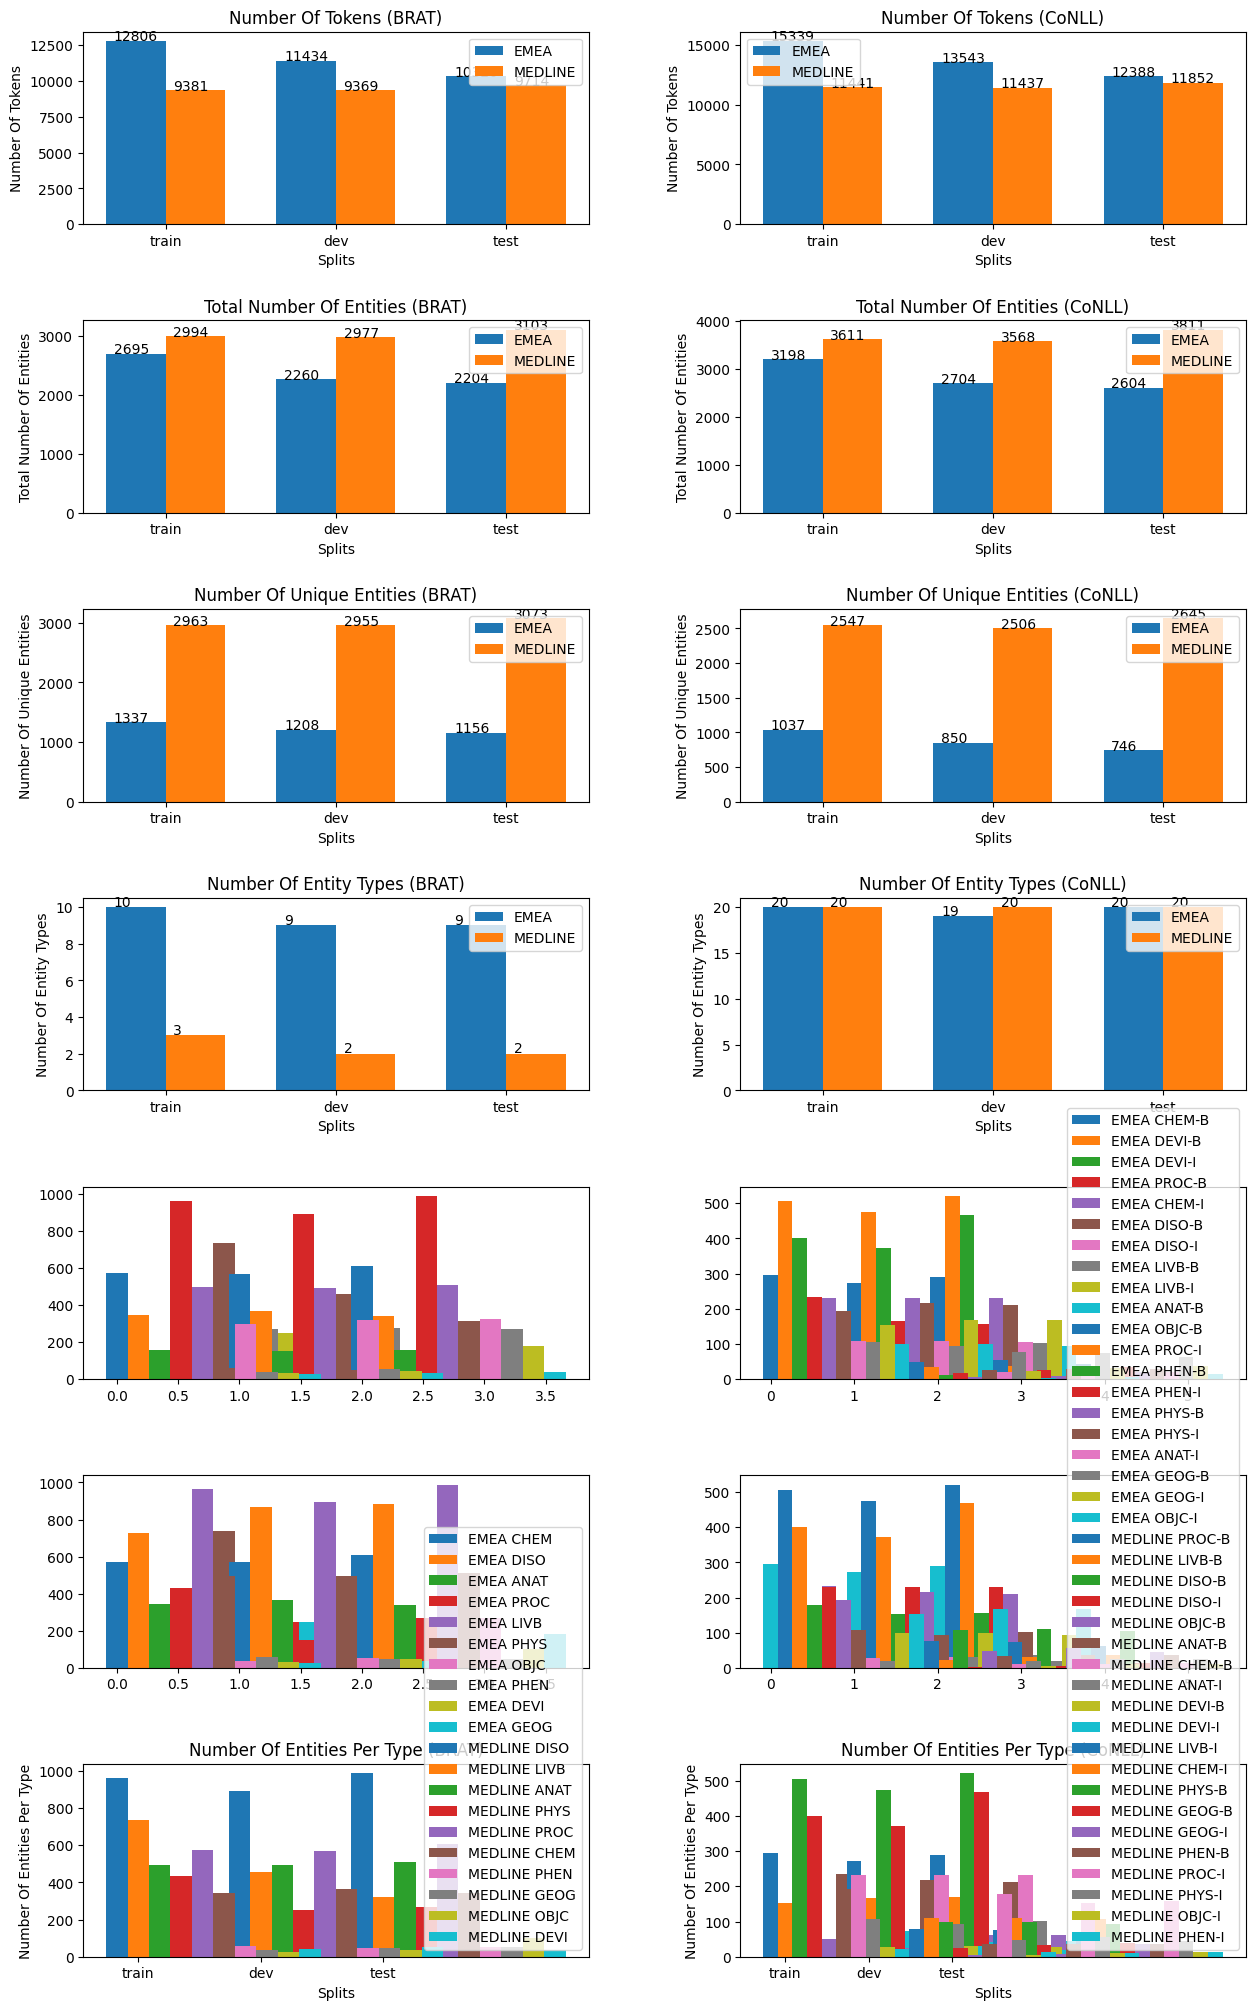

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_statistics(brat_stats, conll_stats):
    # Define subsets and splits
    subsets = ['EMEA', 'MEDLINE']
    splits = ['train', 'dev', 'test']
    categories = ['number_of_tokens', 'total_number_of_entities', 'number_of_unique_entities', 'number_of_entity_types', 'number_of_entities_per_type']
    
    # Create a 7x2 subplot for each category and each format (BRAT and CoNLL)
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 25))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    for i, category in enumerate(categories):
        for j, data_format in enumerate([brat_stats, conll_stats]):
            ax = axes[i][j]
            
            # Prepare the data for plotting
            data = {
                subset: [data_format[f"{subset}_{split}"].get(category, 0) if isinstance(data_format[f"{subset}_{split}"], dict) else 0
                         for split in splits]
                for subset in subsets
            }
            
            n_groups = len(splits)
            index = np.arange(n_groups)
            bar_width = 0.35
            
            # Create the bar plot
            for k, (subset, counts) in enumerate(data.items()):
                if category == 'number_of_entities_per_type':
                    for spl, entity_count_per_type in enumerate(counts):
                        ax = axes[i+spl][j]
                        print(entity_count_per_type)
                        ax.bar([ct.get(entity_type, 0) for ct in counts],
                            bar_width / len(subsets), label=f"{subset} {entity_type}")
                            # # Add labels for each bar
                            # for idx, value in enumerate([ct.get(entity_type, 0) for ct in counts]):
                            #     ax.text(idx + l * bar_width / len(subsets) - 0.13, value + 0.05, str(value))
                        
                    
                        # Special handling for dictionary of counts
                        # for l, (entity_type, count) in enumerate(counts[0].items()):
                        #     ax.bar(index + l * bar_width / len(subsets), [ct.get(entity_type, 0) for ct in counts],
                        #         bar_width / len(subsets), label=f"{subset} {entity_type}")
                            # # Add labels for each bar
                            # for idx, value in enumerate([ct.get(entity_type, 0) for ct in counts]):
                            #     ax.text(idx + l * bar_width / len(subsets) - 0.13, value + 0.05, str(value))
                else:
                    ax.bar(index + k * bar_width, counts, bar_width, label=subset)
                    # Add labels for each bar
                    for idx, value in enumerate(counts):
                        ax.text(idx + k * bar_width - 0.13, value + 0.05, str(value))

                    # Add labels, title, and legend
                    ax.set_xlabel('Splits')
                    ax.set_ylabel(category.replace('_', ' ').title())
                    ax.set_title(f'{category.replace("_", " ").title()} ({["BRAT", "CoNLL"][j]})')
                    ax.set_xticks(index + bar_width / 2)
                    ax.set_xticklabels(splits)
            ax.legend()

    # Show the plot
    plt.show()

# Assume `brat_statistics` and `conll_statistics` are dictionaries containing the statistics for each format
# These would be obtained from running the `analyze_corpus` and `get_statistics` functions respectively

# Plot the statistics for both BRAT and CoNLL
# plot_statistics(brat_statistics, conll_statistics) 

# As we do not have the actual data, the function call is commented out. 
# To use this function, you would need to pass the actual statistics obtained from the dataset.
plot_statistics(brat_results, conll_results)